# Relations réciproques entres personnes et avec les institutions

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itables import init_notebook_mode, show
import numpy as np
import seaborn as sns
from netgraph import Graph, InteractiveGraph
from pyvis.network import Network

## Production des données

* Requête exécutée sur le serveur https://dbpedia.org/sparql 
* Période élargie jusqu'aux comtemporains-nes
* Propriétés prises en compte après inspection des propriétés de la population:
  * http://dbpedia.org/ontology/almaMater 
  * http://dbpedia.org/ontology/institution


```SPARQL
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
SELECT DISTINCT (?o1 AS ?subject_uri) ?subjectBirthDate ?r_property  ?target 
# (COUNT(*) AS ?effectif) 
WHERE {
  SELECT DISTINCT ?o1 ?subjectBirthDate ?r_property  ?target 
  WHERE { 
    {
          {dbr:List_of_astronomers ?p ?o1.}
      UNION
          {dbr:List_of_astrologers ?p ?o1.}
      UNION
          {?o1 ?p dbr:Astrologer.}
      UNION
          {?o1 ?p dbr:Astronomer.}
      UNION
          {?o1 ?p dbr:Mathematician.}
    }
    ?o1 a dbo:Person;
      dbp:birthDate | dbo:birthDate ?subjectBirthDate.
     {
        {?o1 dbo:almaMater ?target.
     BIND('almaMater' AS ?r_property) }
UNION  {?o1 dbo:institution ?target.
     BIND('institution' AS ?r_property) }
#UNION  {?o1 dbp:fields ?target.
#     BIND('fields' AS ?r_property) }
#UNION  {?o1 dbp:field ?target.
#     BIND('field' AS ?r_property) }
}

    BIND(xsd:integer(SUBSTR(STR(?subjectBirthDate), 1, 4)) AS ?birthYear)
    FILTER ( (?birthYear >= 1451   ))
 
          }
  ORDER BY ?birthYear
  }

```

In [2]:
### Ouvrir le fichier et créer un DataFrame
fd = 'data/dbpedia_sparql_relations.csv'
df = pd.read_csv(fd)
len(df)

7136

In [3]:
### Raccourcir l'URI, extraire l'année de naissance
df['subject_uri'] = df['subject_uri'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
df['target'] = df['target'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
df['BirthYear'] = df['subjectBirthDate'].apply(lambda x : int(x[:4]))

In [4]:
### Ajouter deux périodes différentes en fonctions de la relation
# Pour la relation 'étudier' créer une période entre 18 et 28 ans (+17, +27) pour l'étendue des études
# Pour la relation 'insitution' ajouté une période d'activité de 19 à 65 ans
df['YBegin'] = df[['BirthYear', 'r_property']].apply(lambda x : int(x['BirthYear'] + 17) if x['r_property'] == 'almaMater' else int(x['BirthYear'] + 27), axis=1)
df['YEnd'] = df[['BirthYear', 'r_property']].apply(lambda x : int(x['BirthYear'] + 28) if x['r_property'] == 'almaMater' else int(x['BirthYear'] + 64), axis=1)

In [5]:
### Inspecter DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7136 entries, 0 to 7135
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subject_uri       7136 non-null   object
 1   subjectBirthDate  7136 non-null   object
 2   r_property        7136 non-null   object
 3   target            7136 non-null   object
 4   BirthYear         7136 non-null   int64 
 5   YBegin            7136 non-null   int64 
 6   YEnd              7136 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 390.4+ KB


In [6]:
### Inspecter la distribution des années de naissance
df.BirthYear.describe()

count    7136.000000
mean     1913.805914
std        55.868705
min      1454.000000
25%      1899.000000
50%      1926.000000
75%      1947.000000
max      1989.000000
Name: BirthYear, dtype: float64

In [7]:
df.head()

subject_uri subjectBirthDate r_property  \
0  Domenico_Maria_Novara_da_Ferrara       1454-08-01  almaMater   
1                Scipione_del_Ferro       1465-02-06  almaMater   
2        Heinrich_Cornelius_Agrippa       1486-09-14  almaMater   
3                    Michael_Stifel             1487  almaMater   
4                  Gerolamo_Cardano       1501-09-24  almaMater   

                     target  BirthYear  YBegin  YEnd  
0    University_of_Florence       1454    1471  1482  
1     University_of_Bologna       1465    1482  1493  
2     University_of_Cologne       1486    1503  1514  
3  University_of_Wittenberg       1487    1504  1515  
4       University_of_Pavia       1501    1518  1529

In [8]:
### Inspecter la table 
# https://github.com/mwouts/itables/blob/main/docs/advanced_parameters.md
show(df[['subject_uri','r_property','target','YBegin','YEnd','BirthYear']].sort_values(by='BirthYear'), classes="display", scrollY="200px", 
     scrollCollapse=True, paging=False, column_filters="footer", dom="lrtip")

In [9]:
### Compter par propriété
df.groupby(by='r_property').size()

r_property
almaMater      4103
institution    3033
dtype: int64

In [10]:
# l_org_orig = list(df.target.unique()); len(l_org_orig), l_org_orig[:3]

In [11]:
### Effectuer et documenter tous les changements: nettoyage des données
df.loc[df.target == 'École_normale_supérieure_(Ulm)', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_normale_supérieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_Normale_Supérieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_Normale_Superieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'Swiss_Federal_Polytechnic', 'target']  = 'ETH_Zürich'
df.loc[df.target == 'Federal_Polytechnic_School', 'target']  = 'ETH_Zürich'
df.loc[df.target == 'Swiss_Federal_Institute_of_Technology_at_Zurich', 'target']  = 'ETH_Zürich'
df.loc[df.target == 'École_polytechnique', 'target']  = 'École_Polytechnique'
df.loc[df.target == 'University_of_Padua', 'target']  = 'Università_di_Padova'
df.loc[df.target == 'University_of_Padova', 'target']  = 'Università_di_Padova'

In [12]:
### Remplacements multiples, contenant Paris et Université
df.loc[(df.target.str.contains('Paris')) & (df.target.str.contains('Univ')), 'target'] = "Université_de_Paris"

In [13]:
organisations = df.groupby(by='target').size()

In [14]:
show(organisations.sort_index(ascending=False))

In [15]:
### Effectif total et les plus représentées
len(organisations), organisations.sort_values(ascending=False).head(10)

(1677,
 target
 Harvard_University                       185
 Princeton_University                     178
 University_of_Cambridge                  173
 Université_de_Paris                      159
 Moscow_State_University                  122
 University_of_Chicago                    121
 University_of_California,_Berkeley       114
 Massachusetts_Institute_of_Technology    112
 University_of_Michigan                    89
 University_of_Göttingen                   87
 dtype: int64)

### Explorer les années de naissance

In [16]:
### Créer une série qui contient les années de naissance
s = df.BirthYear

(1801.0, 1900.0)

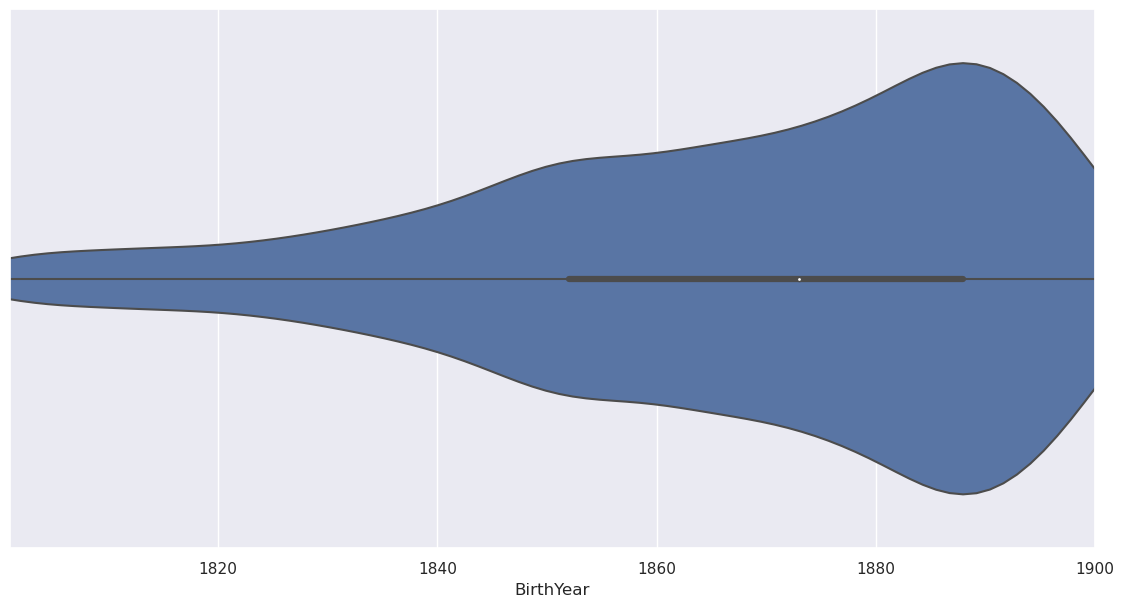

In [17]:
### Violinplot : densité des naissances dans le temps
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

sns.set_theme(style="whitegrid")

sns.set(rc={"figure.figsize":(14, 7)})

### Personnes nées avant 1931 (protection des données)
# a = s[(s<1931)] 
## Période pré-scientifique
a = s[(s<1801)]
## Décollage de la science 'moderne'
a = s[(s>1800) & (s<1901)] # 
## Science contemporaine
# a = s[(s>1900) ] # 
lim_left=min(a)
lim_right=max(a)





ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=lim_left, right=lim_right)


#### Coder les périodes

In [18]:
### Choisir les années qui délimitent les époques
bins=[1001,1801,1901,2021]

In [19]:
### avec la fonction 'cut' on utiliser les limites ('bins') pour créer les périodes
df['periode'] = pd.cut(df['BirthYear'], bins=bins, right=False  )
df.periode = df.periode.apply( lambda x : str(x.left) + '_' + str(x.right))

In [20]:
df.head()

subject_uri subjectBirthDate r_property  \
0  Domenico_Maria_Novara_da_Ferrara       1454-08-01  almaMater   
1                Scipione_del_Ferro       1465-02-06  almaMater   
2        Heinrich_Cornelius_Agrippa       1486-09-14  almaMater   
3                    Michael_Stifel             1487  almaMater   
4                  Gerolamo_Cardano       1501-09-24  almaMater   

                     target  BirthYear  YBegin  YEnd    periode  
0    University_of_Florence       1454    1471  1482  1001_1801  
1     University_of_Bologna       1465    1482  1493  1001_1801  
2     University_of_Cologne       1486    1503  1514  1001_1801  
3  University_of_Wittenberg       1487    1504  1515  1001_1801  
4       University_of_Pavia       1501    1518  1529  1001_1801

In [21]:
### Effectif par période
df.groupby(by='periode').size()

periode
1001_1801     256
1801_1901    1578
1901_2021    5302
dtype: int64

In [22]:
### On transforme le DataFrame en dictionnaire pour pouvoir ensuite effectuer des opérations
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html
ldf = df[['subject_uri', 'r_property', 'target',
       'YBegin', 'YEnd', 'BirthYear', 'periode']].sort_values(by='subject_uri').to_dict('records')

In [23]:
ldf[:2]

[{'subject_uri': "'Mamphono_Khaketla",
  'r_property': 'almaMater',
  'target': 'University_of_Wisconsin',
  'YBegin': 1977,
  'YEnd': 1988,
  'BirthYear': 1960,
  'periode': '1901_2021'},
 {'subject_uri': 'A._E._Douglass',
  'r_property': 'almaMater',
  'target': 'Hartford',
  'YBegin': 1884,
  'YEnd': 1895,
  'BirthYear': 1867,
  'periode': '1801_1901'}]

## Graphe à deux types de sommets


Il s'agit d'un graphe de type 'bipartite', cf. la documentation de Networkx:

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html

Nous n'utilisons toutefois pas ici les fonctions spécifiques de Neworkx.

In [24]:
### A partir du dictionnaire précédent, on créer ici un graphe bipartite:
# dans les tuples ci-dessous on a comme source ou origine la personne et comme cible l'université.
# Ce sont les relations qu'on va transformer en graphe, tout en ajoutant quelques attributs.
# Noter le filtre temporal, ici très large, mais qu'on pourrait affiner
l = []
for i in ldf:
    if i['periode'] == '1001_1801':
        l.append(tuple((i['subject_uri'],i['target'], 
                        {'relationship': i['r_property'], "birth_year": i['BirthYear'], "periode": i['periode'] })))
l[:5]

[('Abraham_de_Moivre',
  'Academy_of_Saumur',
  {'relationship': 'almaMater', 'birth_year': 1667, 'periode': '1001_1801'}),
 ('Adolphe_Quetelet',
  'University_of_Ghent',
  {'relationship': 'almaMater', 'birth_year': 1796, 'periode': '1001_1801'}),
 ('Adriaan_Metius',
  'University_of_Franeker',
  {'relationship': 'almaMater', 'birth_year': 1571, 'periode': '1001_1801'}),
 ('Adrien-Marie_Legendre',
  'Collège_Mazarin',
  {'relationship': 'almaMater', 'birth_year': 1752, 'periode': '1001_1801'}),
 ('Anders_Celsius',
  'Uppsala_University',
  {'relationship': 'almaMater', 'birth_year': 1701, 'periode': '1001_1801'})]

In [25]:
# On crée ici un graphe vide
POG=nx.Graph()

In [26]:
# On ajouter les relation préparées en amont en tant qu'arêtes (edges) du graphe,
# qui sera donc non-orienté
POG.add_edges_from(l)

In [27]:
### Principales caractéristiques de ce graphe
# Noter que le graphe n'est pas connecté, i.e. qu'il y a des ilôts séparés

POG.is_multigraph(), POG.is_directed(), nx.is_connected(POG), POG.number_of_nodes(), POG.number_of_edges(), nx.density(POG)


(False, False, False, 313, 241, 0.004935692635373147)

In [28]:
### Créer une liste des organisations
# Noter que la série des organisations a été créée plus haut
# L'index de la sérier est le nom de l'organisation
l_org = list(organisations.index); len(l_org); l_org[:3]

['AT&T_Bell_Laboratories', 'AT&T_Labs', 'Aarhus_University']

In [29]:
### On récupère ici la liste des sommets (notes) et on prend les 4 premiers
list(POG.nodes.data())[:4]

[('Abraham_de_Moivre', {}),
 ('Academy_of_Saumur', {}),
 ('Adolphe_Quetelet', {}),
 ('University_of_Ghent', {})]

In [30]:
### Ajouter au sommets un code en fonction 
# qu'il s'agit d'une personne ou organisation
# On utiliser pour ce faire la liste des organisations précédemment constituée:
# si le nom est dans la liste, ça devient une organisation —> 'O'
types = {}
for e in list(POG.nodes):
    if e in l_org:
        t = 'O'
    else:
        t = 'P'
    types[e] = {'type': t} 
[(k,v )for k,v in types.items()][:3]  

[('Abraham_de_Moivre', {'type': 'P'}),
 ('Academy_of_Saumur', {'type': 'O'}),
 ('Adolphe_Quetelet', {'type': 'P'})]

In [31]:
### On ajoute l'attribut du type (P ou O) aux sommets,
# on pourra ensuite leur attribuer des couleurs différentes
nx.set_node_attributes(POG, types)
list(POG.nodes.data())[:3]

[('Abraham_de_Moivre', {'type': 'P'}),
 ('Academy_of_Saumur', {'type': 'O'}),
 ('Adolphe_Quetelet', {'type': 'P'})]

### Inspecter les centralités de degré

In [32]:
### Ajouter la centralité de degré
# grâce à un dictionnaire construit selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(POG)])

In [93]:
### Les valeurs sont ici associées aux sommets
nx.set_node_attributes(POG, degree)
print(list(POG.nodes.data())[:4])

[('Abraham_de_Moivre', {'type': 'P', 'degree': 1, 'label': 'Abraham de Moivre'}), ('Academy_of_Saumur', {'type': 'O', 'degree': 1, 'label': 'Academy of Saumur'}), ('Adolphe_Quetelet', {'type': 'P', 'degree': 1, 'label': 'Adolphe Quetelet'}), ('University_of_Ghent', {'type': 'O', 'degree': 1, 'label': 'University of Ghent'})]


In [35]:
### Inspecter les degrés des personnes:
# on créer ici une liste avec la personne et son degré de centralité,
# c'est-à-dire le nombre d'universités avec lesquelles il a été associé
persons_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'P':
        persons_degree.append([n[0], n[1]['degree']])

## Les degrés de centralité les plus élevés, i.e. fréquentation de plusieurs universités
sorted(persons_degree, key = lambda x : x[1], reverse=True)[:10]

[['Joseph_Johann_von_Littrow', 6],
 ['Andreas_von_Ettingshausen', 3],
 ['Carl_Friedrich_Gauss', 3],
 ['David_Gregory_(mathematician)', 3],
 ['Denison_Olmsted', 3],
 ['Geminiano_Montanari', 3],
 ['Gilles_de_Roberval', 3],
 ['Isaac_Newton', 3],
 ['James_Ivory_(mathematician)', 3],
 ['Jean-Alfred_Gautier', 3]]

In [36]:
### On inspecte ici le degré des organisation:
#  nombre de personnes qui leur sont associées
org_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'O':
        org_degree.append([n[0], n[1]['degree']])

## Tri par effectif décroissant
sorted(org_degree, key = lambda x : x[1], reverse=True)[:10]

[['Trinity_College,_Cambridge', 14],
 ['École_Polytechnique', 13],
 ['University_of_Göttingen', 8],
 ['Università_di_Padova', 7],
 ['University_of_Pisa', 6],
 ["St_John's_College,_Cambridge", 6],
 ['University_of_Edinburgh', 6],
 ['University_of_Copenhagen', 5],
 ['University_of_Bologna', 5],
 ['University_of_Geneva', 4]]

In [37]:
### On inspecte ici la structure des arêtes (edges), i.e. ce n'est pas des arcs
# qui sont des relations orientées
edges = list(POG.edges.data())
edges[:5]

[('Abraham_de_Moivre',
  'Academy_of_Saumur',
  {'relationship': 'almaMater', 'birth_year': 1667, 'periode': '1001_1801'}),
 ('Adolphe_Quetelet',
  'University_of_Ghent',
  {'relationship': 'almaMater', 'birth_year': 1796, 'periode': '1001_1801'}),
 ('Adriaan_Metius',
  'University_of_Franeker',
  {'relationship': 'almaMater', 'birth_year': 1571, 'periode': '1001_1801'}),
 ('Adrien-Marie_Legendre',
  'Collège_Mazarin',
  {'relationship': 'almaMater', 'birth_year': 1752, 'periode': '1001_1801'}),
 ('Anders_Celsius',
  'Uppsala_University',
  {'relationship': 'almaMater', 'birth_year': 1701, 'periode': '1001_1801'})]

In [38]:
### Ajouter aux sommets des labels sans traits sous la ligne

labels = {}    
for node in POG.nodes():
    ## remplacer les traits sous la ligne par un espace
    labels[node] = node.replace('_', ' ')

## ajouter les labels aux sommets 
nx.set_node_attributes(POG, labels, 'label')

## Inspecter
nodes = list(POG.nodes.data())
nodes[:5]

[('Abraham_de_Moivre',
  {'type': 'P', 'degree': 1, 'label': 'Abraham de Moivre'}),
 ('Academy_of_Saumur',
  {'type': 'O', 'degree': 1, 'label': 'Academy of Saumur'}),
 ('Adolphe_Quetelet', {'type': 'P', 'degree': 1, 'label': 'Adolphe Quetelet'}),
 ('University_of_Ghent',
  {'type': 'O', 'degree': 1, 'label': 'University of Ghent'}),
 ('Adriaan_Metius', {'type': 'P', 'degree': 1, 'label': 'Adriaan Metius'})]

### Analyser les composantes du graphe

Comme ce graphe n'est pas connecté (cf. ci-dessus) ça veut dire qu'il contient plusieurs ilôts qui ne sont par reliés entre eux. Ces ilôts sont appelés 'composantes' (_components_)

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [39]:
### Créer une variable qui contient la liste des composantes
components = nx.connected_components(POG);
components_l = [len(c) for c in sorted(nx.connected_components(POG), key=len, reverse=True)]

## il y a 75 components dans le graphe, et voici le nombre de sommets des premiers 10
# Etant donné que le graphe est bipartite, en dessous de 10 sommets environ les graphes 
# seront très petits ou simplement comportant des personnes isolées,
# comme c'est le cas pour la moitié des traphes ici
len(components_l), components_l[:10]

(75, [24, 22, 17, 15, 14, 12, 11, 10, 9, 7])

count    75.000000
mean      4.173333
std       4.518351
min       2.000000
25%       2.000000
50%       2.000000
75%       4.000000
max      24.000000
dtype: float64


[]

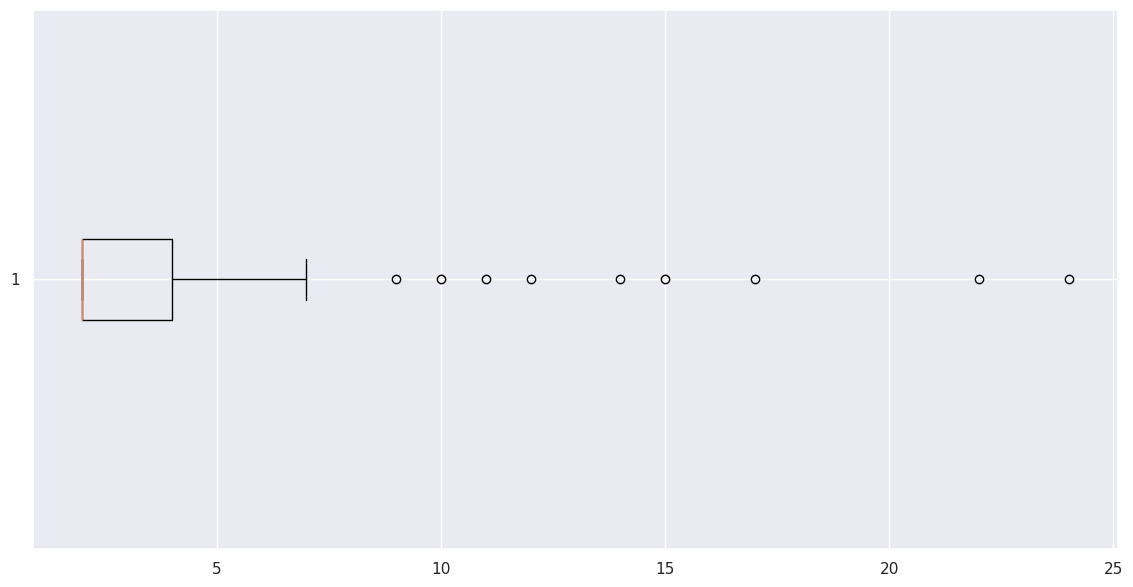

In [40]:
### Distribution des effectifs des graphes
print(pd.Series(components_l).describe())
ax = plt.boxplot(components_l, vert=False)
plt.plot()

In [41]:
### Créer à partir des sets de sommets qui forment les components un ensemble de sousgraphes
# Ces ensemble de sous-graphes est stocké dans la liste S
S = [POG.subgraph(c).copy() for c in nx.connected_components(POG)]

In [42]:
### i correspond à la position de la composante dans la liste S, len(s.nodes) à l'effectif des sommets
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True)
ln[:5]

[[14, 24], [8, 22], [18, 17], [15, 15], [31, 14]]

### Représenter les composantes du graphe

In [43]:
### Graphes qui contiennent 7 sommets
# Dans le premier deux sont des organisations,cinq des personnes
# Dans le deuxième il n'y a que une organisation et les autres sont des personnes
p1 = [print(S[i[0]].nodes) for i in ln if i[1] == 7 ]
 

['Georg_Joachim_Rheticus', 'August_Ferdinand_Möbius', 'Erasmus_Reinhold', 'Michael_Stifel', 'University_of_Leipzig', 'Johann_Karl_Burckhardt', 'University_of_Wittenberg']
['John_Craig_(mathematician)', 'John_Dawson_(surgeon)', 'Robert_Hamilton_(economist)', 'James_Short_(mathematician)', 'David_Brewster', 'Thomas_Brisbane', 'University_of_Edinburgh']
['Marischal_College', 'Robert_Brown_(botanist,_born_1773)', 'Willebrord_Snellius', 'David_Gregory_(mathematician)', 'British_Museum', 'University_of_Aberdeen', 'University_of_Leiden']
['Denison_Olmsted', 'University_of_North_Carolina_at_Chapel_Hill', 'Nehemiah_Strong', 'Yale_College', 'Theodore_Strong', 'Jared_Mansfield', 'Yale_University']


In [44]:
### Sélectionner les graphes à représenter
gi = [i[0] for i in ln if i[1] == 7 ]
### ou alternativement pour les composantes de plus de 10 sommets
# décommenter pour exécuter
# gi = [i[0] for i in ln if i[1] > 9]



In [45]:
### Créer le graphe à représenter, 'u', par addition 
# des composantes retenues
u = nx.Graph()
for i in gi:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    u = nx.union(u, S[i])
type(u)    

networkx.classes.graph.Graph

In [46]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

print(u.is_multigraph(), u.is_directed(), nx.is_connected(u), 
'\n--------'),
len([a for a in nx.connected_components(u)]), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


False False False 
--------


(4, 28, 24, 0.06349206349206349)

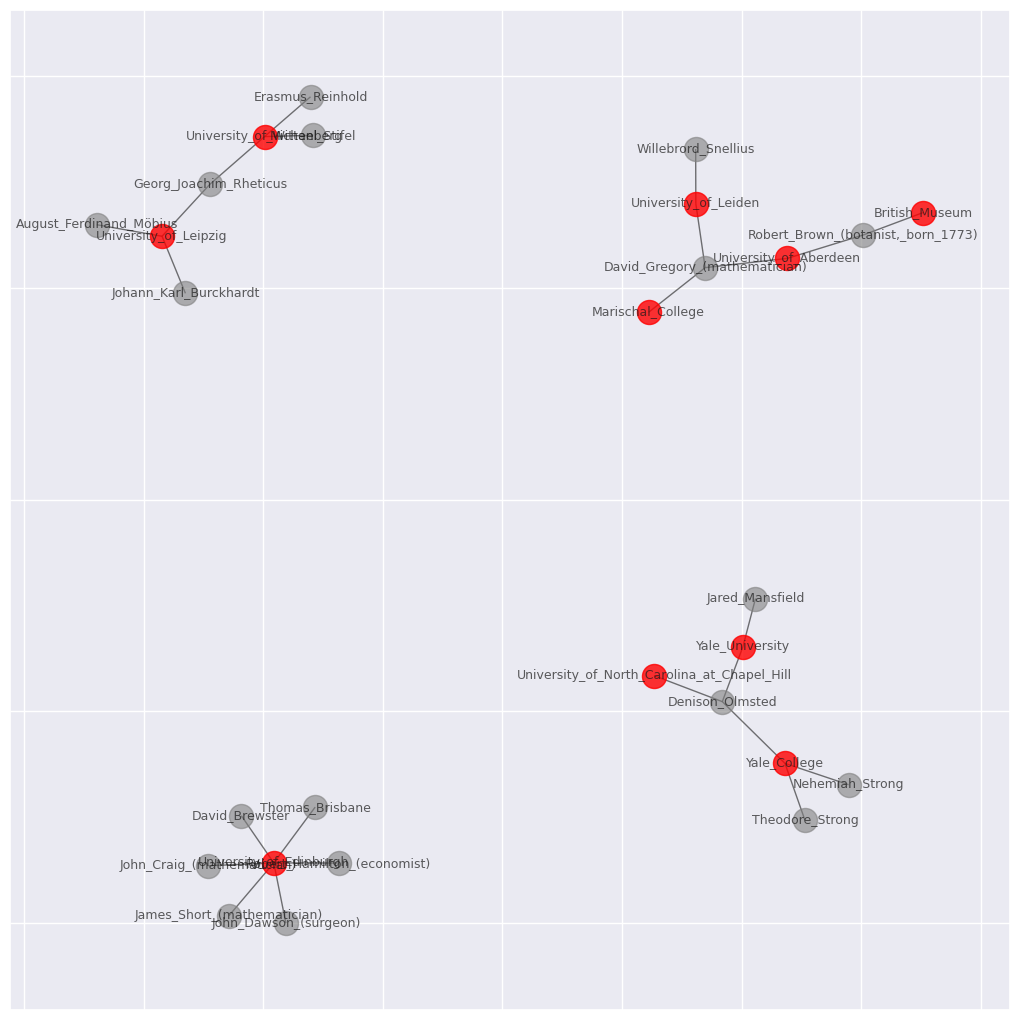

In [47]:
### Visualiser les "écoles", i.e. quelles personnes 
# ont étudié dans la même Université
# Les résultats peuvent être très divers, des grappes denses
# ou une grande dispersion


# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

## on définit ici l'algorythme avec lequel le traphe sera représenté
#pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)

## deux listes pour sommets de deux types, avec les couleurs relatives
no = [x for x,y in g.nodes(data=True) if y['type']=='O']
np = [x for x,y in g.nodes(data=True) if y['type']=='P'] 
co = 'red'
cp = 'grey'


### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos, nodelist=np, node_color=cp, alpha=0.6)
nx.draw_networkx_nodes(g, pos, nodelist=no, node_color=co, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=9)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
plt.savefig('pictures/composantes_bipartite.jpg')
plt.show()


In [48]:
### On utilise pyvis pour une représentation HTML intéracive, page à part qu'on peut 
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
nt = Network() #filter_menu=True) #notebook=True) #
# populates the nodes and edges data structures
nt.from_nx(u)

In [49]:
### NB: cette partie fonctionne seulement si une connection internet
# est disponible. Noter aussi que s'il y a beaucoup de sommets c'est très long
nt.save_graph('pictures/nx_s.html')

## si ça ne s'ouvre pas directement dans un navigateur web, 
# ouvrir manuellement le fichier HTML

### Créer les paires de personnes

Personnes ayant étudié dans la même université, à la même époque:

* on teste si c'est la même université
* on teste s'il y a superposition des périodes

In [50]:
### Trier d'abord la liste
ldf = sorted(ldf, key=lambda k: k['subject_uri'])
ldf[:3] 

[{'subject_uri': "'Mamphono_Khaketla",
  'r_property': 'almaMater',
  'target': 'University_of_Wisconsin',
  'YBegin': 1977,
  'YEnd': 1988,
  'BirthYear': 1960,
  'periode': '1901_2021'},
 {'subject_uri': 'A._E._Douglass',
  'r_property': 'almaMater',
  'target': 'Hartford',
  'YBegin': 1884,
  'YEnd': 1895,
  'BirthYear': 1867,
  'periode': '1801_1901'},
 {'subject_uri': 'A._E._Douglass',
  'r_property': 'almaMater',
  'target': 'Trinity_College_(Connecticut)',
  'YBegin': 1884,
  'YEnd': 1895,
  'BirthYear': 1867,
  'periode': '1801_1901'}]

In [51]:
### Créer les pairs de personnes
# Afin d'éviter les doublons s2 doit être plus grand que s1
pairs_p = []

for s1 in ldf:
    for s2 in ldf:
        if s1['subject_uri'] < s2['subject_uri'] \
            and s1['target'] == s2['target'] \
            and s2['YEnd'] > s1['YBegin'] \
            and s2['YBegin'] < s1['YEnd']:
            pairs_p.append([s1,s2])
        else:
            pass

In [52]:
print(len(pairs_p))
pairs_p[:2]

47266


[[{'subject_uri': "'Mamphono_Khaketla",
   'r_property': 'almaMater',
   'target': 'University_of_Wisconsin',
   'YBegin': 1977,
   'YEnd': 1988,
   'BirthYear': 1960,
   'periode': '1901_2021'},
  {'subject_uri': 'Marvin_Knopp',
   'r_property': 'institution',
   'target': 'University_of_Wisconsin',
   'YBegin': 1960,
   'YEnd': 1997,
   'BirthYear': 1933,
   'periode': '1901_2021'}],
 [{'subject_uri': 'A._M._Mathai',
   'r_property': 'institution',
   'target': 'McGill_University',
   'YBegin': 1962,
   'YEnd': 1999,
   'BirthYear': 1935,
   'periode': '1901_2021'},
  {'subject_uri': 'Carl_S._Herz',
   'r_property': 'institution',
   'target': 'McGill_University',
   'YBegin': 1957,
   'YEnd': 1994,
   'BirthYear': 1930,
   'periode': '1901_2021'}]]

### Créer les pairs d'organisations

Une personne fait le lien entre deux organisations. Dans ce cas la date n'est pas nécessaire.

In [53]:
## Pairs d'organisations
pairs_o = []

for s1 in ldf:
    for s2 in ldf:
        if s1['target'] < s2['target'] \
            and s1['subject_uri'] == s2['subject_uri']:
                pairs_o.append([s1,s2])
        else:
            pass

In [54]:
print(len(pairs_o))
pairs_o[:2]

8338


[[{'subject_uri': 'A._E._Douglass',
   'r_property': 'almaMater',
   'target': 'Hartford',
   'YBegin': 1884,
   'YEnd': 1895,
   'BirthYear': 1867,
   'periode': '1801_1901'},
  {'subject_uri': 'A._E._Douglass',
   'r_property': 'almaMater',
   'target': 'Trinity_College_(Connecticut)',
   'YBegin': 1884,
   'YEnd': 1895,
   'BirthYear': 1867,
   'periode': '1801_1901'}],
 [{'subject_uri': 'A._M._Mathai',
   'r_property': 'institution',
   'target': 'McGill_University',
   'YBegin': 1962,
   'YEnd': 1999,
   'BirthYear': 1935,
   'periode': '1901_2021'},
  {'subject_uri': 'A._M._Mathai',
   'r_property': 'almaMater',
   'target': 'Palai',
   'YBegin': 1952,
   'YEnd': 1963,
   'BirthYear': 1935,
   'periode': '1901_2021'}]]

## Réseaux de personnes (filtres, sous-populations)

In [55]:
earlyModern_pairs = [p for p in pairs_p if ((p[0]['periode']=='1001_1801') & (p[1]['periode']=='1001_1801'))]

In [56]:
_19th_century_pairs = [p for p in pairs_p if ((p[0]['periode']=='1801_1901') & (p[1]['periode']=='1801_1901'))]

In [57]:
len(_19th_century_pairs), _19th_century_pairs[:2]

(3260,
 [[{'subject_uri': 'Abraham_Fraenkel',
    'r_property': 'almaMater',
    'target': 'University_of_Marburg',
    'YBegin': 1908,
    'YEnd': 1919,
    'BirthYear': 1891,
    'periode': '1801_1901'},
   {'subject_uri': 'Helmut_Hasse',
    'r_property': 'almaMater',
    'target': 'University_of_Marburg',
    'YBegin': 1915,
    'YEnd': 1926,
    'BirthYear': 1898,
    'periode': '1801_1901'}],
  [{'subject_uri': 'Abraham_Fraenkel',
    'r_property': 'almaMater',
    'target': 'University_of_Marburg',
    'YBegin': 1908,
    'YEnd': 1919,
    'BirthYear': 1891,
    'periode': '1801_1901'},
   {'subject_uri': 'Reinhold_Strassmann',
    'r_property': 'almaMater',
    'target': 'University_of_Marburg',
    'YBegin': 1910,
    'YEnd': 1921,
    'BirthYear': 1893,
    'periode': '1801_1901'}]])

In [58]:
### filtre sur la propriété
almaMater_pairs = [p for p in pairs_p if ((p[0]['r_property'] == 'almaMater') & (p[1]['r_property'] == 'almaMater'))]

In [59]:
len(almaMater_pairs), almaMater_pairs[:2]

(14151,
 [[{'subject_uri': 'A._O._L._Atkin',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1942,
    'YEnd': 1953,
    'BirthYear': 1925,
    'periode': '1901_2021'},
   {'subject_uri': 'Abdus_Salam',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1943,
    'YEnd': 1954,
    'BirthYear': 1926,
    'periode': '1901_2021'}],
  [{'subject_uri': 'A._O._L._Atkin',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1942,
    'YEnd': 1953,
    'BirthYear': 1925,
    'periode': '1901_2021'},
   {'subject_uri': 'Anthony_James_Merrill_Spencer',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1946,
    'YEnd': 1957,
    'BirthYear': 1929,
    'periode': '1901_2021'}]])

## Exploration des graphes de personnes

In [210]:
### Préparer le graphe
# On retient comme source et cible de la relation les personnes
# et le lien est l'université fréquentée en même temps
l = []
for i in _19th_century_pairs: #almaMater_pairs:
    l.append(tuple((i[0]['subject_uri'],i[1]['subject_uri'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}", 
                                                              'organisation': i[0]['target'] })))
l[:5]

[('Abraham_Fraenkel',
  'Helmut_Hasse',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Marburg'}),
 ('Abraham_Fraenkel',
  'Reinhold_Strassmann',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Marburg'}),
 ('Abraham_Fraenkel',
  'Binyamin_Amirà',
  {'relationship': 'institution_institution',
   'organisation': 'Hebrew_University_of_Jerusalem'}),
 ('Adolf_Berberich',
  'Fritz_Cohn',
  {'relationship': 'institution_institution',
   'organisation': 'Astronomical_Calculation_Institute_(Heidelberg_University)'}),
 ('Adolf_Berberich',
  'Elwin_Bruno_Christoffel',
  {'relationship': 'almaMater_institution',
   'organisation': 'University_of_Strasbourg'})]

In [211]:
### On créé le graphe et on ajoute les relations 
# à partir de la liste
EMP=nx.Graph()
EMP.add_edges_from(l)

In [212]:
### Principales propriétés de ce graphe

print(EMP.is_multigraph(), EMP.is_directed(), nx.is_connected(EMP),
'\n----------\n', nx.number_connected_components(EMP), EMP.number_of_nodes(), EMP.number_of_edges(), nx.density(EMP))


False False False 
----------
 23 625 2838 0.014553846153846153


### Analyser les composantes du graphe


Représenter un graphe de cette dimension et complexité n'a pas beaucoup de sens. Mieux vaut analyser et représenter les composantes

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [213]:
### On relèvera la composante principale
components = nx.connected_components(EMP);
components_l = [len(c) for c in sorted(nx.connected_components(EMP), key=len, reverse=True)]
len(components_l), components_l[:5]

(23, [547, 9, 9, 8, 6])

In [214]:
### créer une liste contenant les sous-graphes
# on observe qu'il y a un enorme graphe principal
# et quelques sous-graphes
S = [EMP.subgraph(c).copy() for c in nx.connected_components(EMP)]
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[0, 547], [1, 9], [6, 9], [3, 8], [7, 6], [4, 5], [2, 4], [20, 4]]

In [215]:
### On prépare la liste des index des graphes
# en ordre décroissant de dimension
li=[n[0] for n in ln]

### Représenter le graphe

In [216]:
### On créer le graphe à inspecter par addition des sous-graphes
u = nx.Graph()
for i in li[1:5]:
    u = nx.union(u, S[i])
type(u)    

networkx.classes.graph.Graph

In [217]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975), u.is_multigraph(), u.is_directed(), 
u.number_of_nodes(), u.number_of_edges(), nx.density(u),  nx.number_connected_components(u)


(32, 62, 0.125, 4)

In [218]:
## Créer les labels des sommets
 
labels = {}    
for node in u.nodes():
    labels[node] = node.replace('_',' ')

## ajouter les labels aux sommets 
nx.set_node_attributes(u, labels, 'label')

## Inspecter
nodes = list(u.nodes.data())
nodes[:5]

[('Poul_Heegaard', {'label': 'Poul Heegaard'}),
 ('Niels_Bohr', {'label': 'Niels Bohr'}),
 ('Niels_Nielsen_(mathematician)', {'label': 'Niels Nielsen (mathematician)'}),
 ('Agner_Krarup_Erlang', {'label': 'Agner Krarup Erlang'}),
 ('Carl_Størmer', {'label': 'Carl Størmer'})]

In [219]:
### Inspection des arêtes
edges = list(EMP.edges.data())
edges[:5]

[('Abraham_Fraenkel',
  'Helmut_Hasse',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Marburg'}),
 ('Abraham_Fraenkel',
  'Reinhold_Strassmann',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Marburg'}),
 ('Abraham_Fraenkel',
  'Binyamin_Amirà',
  {'relationship': 'institution_institution',
   'organisation': 'Hebrew_University_of_Jerusalem'}),
 ('Helmut_Hasse',
  'Arnold_Walfisz',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Göttingen'}),
 ('Helmut_Hasse',
  'Binyamin_Amirà',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Göttingen'})]

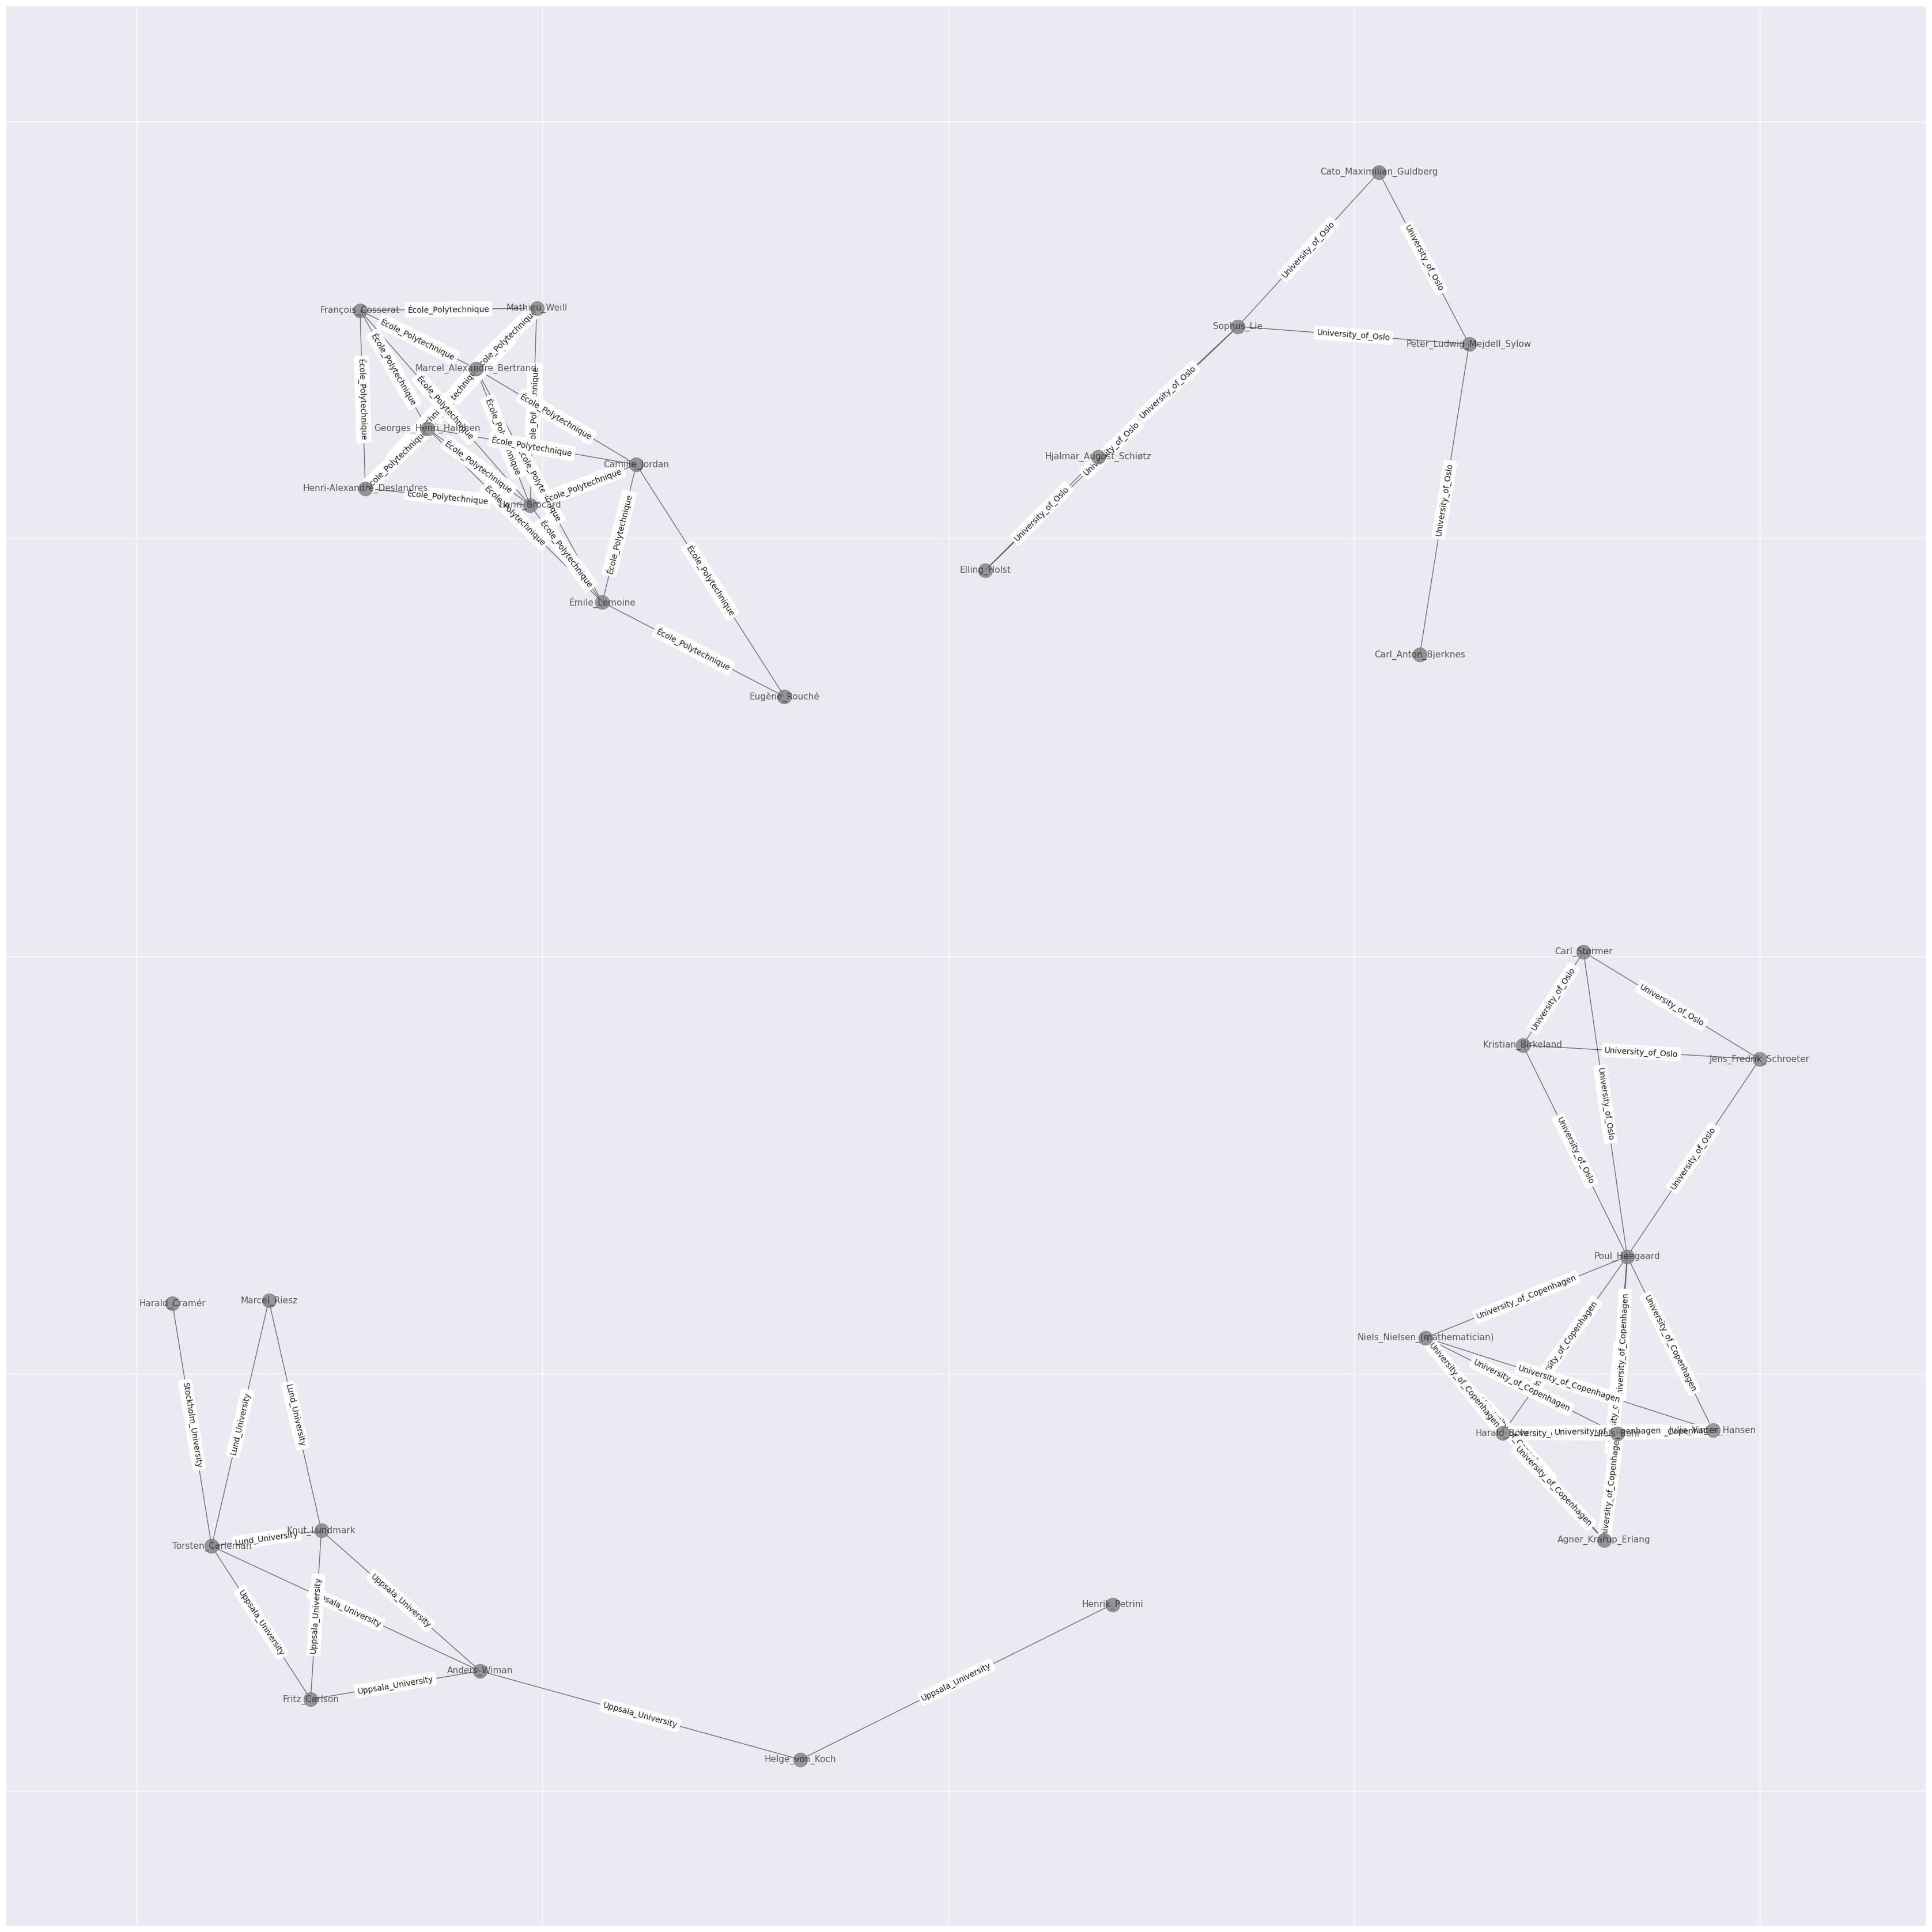

In [123]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (50,50))


g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(g, k=0.5)

edge_labels = {e: u.get_edge_data(e[0], e[1])["organisation"] for e in u.edges()}

cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_color=cp, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=11)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_labels)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('pictures/emp_s.jpg')
plt.show()


La représentation graphique ci-dessus permet d'inspecter les liens entre personnes et de voir quelles universités ils/elles ont fréquenté en même temps. Cette approche fonctionne uniquement si les graphes sont de taille limitée.

Pour des graphes importants, avec 100 ou plus sommets, il faudra appliquer des filtres pour pouvoir les inspecter et mettre en évidence leurs caractéristiques principales.

Un exemple est fourni ci-dessous

### Simplifier le graphe

Si on veut afficher la composante principale, elle sera très lourde et difficile à inspecter. On peut toutefois simplifier le graphe en filtrant par exemple sur la valeur du degré de centralité. 

In [220]:
### On créer le graphe à inspecter par addition des sous-graphes
u = nx.Graph()
for i in li[:1]:
    u = nx.union(u, S[i])
type(u)    

networkx.classes.graph.Graph

In [221]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975), u.is_multigraph(), u.is_directed(), 
u.number_of_nodes(), u.number_of_edges(), nx.density(u),  nx.number_connected_components(u)


(547, 2744, 0.018375287113861154, 1)

In [134]:
### Afficher le graphe avec pyvis

# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
nt = Network(filter_menu=True, cdn_resources='remote') #  notebook=True) #
# populates the nodes and edges data structures
nt.from_nx(u)
nt.save_graph('pictures/emp_big.html' )

## Le code ci-dessous est à utiliser
# si on veut représenter le graphe directement dans le notebook 
# nt.prep_notebook()
# nt.show('pictures/emp.html' )

In [223]:
### Ajouter la centralité de degré
# grâce à un dictionnaire construit selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(u)])
# [[k,v] for k,v in degree.items()][:5]
### Les valeurs sont ici associées aux sommets
nx.set_node_attributes(u, degree)
print(list(u.nodes.data())[:4])

[('Abraham_Fraenkel', {'degree': 3}), ('Helmut_Hasse', {'degree': 17}), ('Reinhold_Strassmann', {'degree': 2}), ('Binyamin_Amirà', {'degree': 20})]


In [225]:
ln = [[n, data] for n,data in u.nodes(data=True) if data.get("degree")>3] #  
len(ln), ln[:3]

(385,
 [['Helmut_Hasse', {'degree': 17}],
  ['Binyamin_Amirà', {'degree': 20}],
  ['Fritz_Cohn', {'degree': 29}]])

In [230]:
lo = [data['organisation'] for node1, node2, data in u.edges(data=True)]
slo = pd.Series(lo)
slo_gb = slo.groupby(by=slo).size().sort_values(ascending=False)
len(slo_gb),slo_gb.head(30)

(145,
 University_of_Göttingen                  523
 Université_de_Paris                      284
 University_of_Berlin                     258
 Trinity_College,_Cambridge               174
 University_of_Vienna                     171
 Harvard_University                       155
 University_of_Cambridge                  101
 École_normale_supérieure_(Paris)          63
 University_of_Leipzig                     63
 University_of_Turin                       53
 University_of_Chicago                     48
 Columbia_University                       46
 Moscow_State_University                   45
 Princeton_University                      42
 University_of_Michigan                    36
 University_of_Bologna                     32
 University_of_Warsaw                      29
 University_of_Amsterdam                   26
 Johns_Hopkins_University                  24
 University_of_Heidelberg                  23
 University_of_Jena                        20
 University_of_Hamburg      

In [231]:
slo_gb.head(30).index.to_list()

['University_of_Göttingen',
 'Université_de_Paris',
 'University_of_Berlin',
 'Trinity_College,_Cambridge',
 'University_of_Vienna',
 'Harvard_University',
 'University_of_Cambridge',
 'École_normale_supérieure_(Paris)',
 'University_of_Leipzig',
 'University_of_Turin',
 'University_of_Chicago',
 'Columbia_University',
 'Moscow_State_University',
 'Princeton_University',
 'University_of_Michigan',
 'University_of_Bologna',
 'University_of_Warsaw',
 'University_of_Amsterdam',
 'Johns_Hopkins_University',
 'University_of_Heidelberg',
 'University_of_Jena',
 'University_of_Hamburg',
 'University_of_Edinburgh',
 'Sapienza_University_of_Rome',
 'Università_di_Padova',
 'ETH_Zurich',
 'Massachusetts_Institute_of_Technology',
 'Bryn_Mawr_College',
 'Scuola_Normale_Superiore',
 "St_John's_College,_Cambridge"]

In [237]:
### Retenir seulement les arêtes qui correspondent à la liste des universités les plus fréquentées
ln = [(k,i) for k,i,data in u.edges(data=True) if data.get("organisation") in slo_gb.head(30).index.to_list()] #  
ln[:3]

[('Helmut_Hasse', 'Arnold_Walfisz'),
 ('Helmut_Hasse', 'Binyamin_Amirà'),
 ('Helmut_Hasse', 'Carl_Ludwig_Siegel')]

In [238]:
gu2=u.edge_subgraph(ln)

In [239]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975), u.is_multigraph(), u.is_directed(), 
gu2.number_of_nodes(), gu2.number_of_edges(), nx.density(gu2),  nx.number_connected_components(gu2)


(399, 2367, 0.02981070767370688, 4)

In [241]:
### Afficher le graphe avec pyvis

# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
nt = Network(filter_menu=True, cdn_resources='remote') #  notebook=True) #
# populates the nodes and edges data structures
nt.from_nx(gu2)
nt.save_graph('pictures/emp_gu2.html' )

## Le code ci-dessous est à utiliser
# si on veut représenter le graphe directement dans le notebook 
# nt.prep_notebook()
# nt.show('pictures/emp.html' )

## Explorer le graphe des organisations (relation Alma Mater)

In [169]:
### Apparaissent des parcours de vie
pairs_o[:2]

[[{'subject_uri': 'A._E._Douglass',
   'r_property': 'almaMater',
   'target': 'Hartford',
   'YBegin': 1884,
   'YEnd': 1895,
   'BirthYear': 1867,
   'periode': '1801_1901'},
  {'subject_uri': 'A._E._Douglass',
   'r_property': 'almaMater',
   'target': 'Trinity_College_(Connecticut)',
   'YBegin': 1884,
   'YEnd': 1895,
   'BirthYear': 1867,
   'periode': '1801_1901'}],
 [{'subject_uri': 'A._M._Mathai',
   'r_property': 'institution',
   'target': 'McGill_University',
   'YBegin': 1962,
   'YEnd': 1999,
   'BirthYear': 1935,
   'periode': '1901_2021'},
  {'subject_uri': 'A._M._Mathai',
   'r_property': 'almaMater',
   'target': 'Palai',
   'YBegin': 1952,
   'YEnd': 1963,
   'BirthYear': 1935,
   'periode': '1901_2021'}]]

In [170]:
l = []
for i in pairs_o:
    if i[0]['r_property'] == 'almaMater' or  i[1]['r_property'] == 'almaMater':
        l.append(tuple((i[0]['target'],i[1]['target'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}", 
                                                              'personne': i[0]['subject_uri'] })))
len(l), l[:3]        

(5176,
 [('Hartford',
   'Trinity_College_(Connecticut)',
   {'relationship': 'almaMater_almaMater', 'personne': 'A._E._Douglass'}),
  ('McGill_University',
   'Palai',
   {'relationship': 'institution_almaMater', 'personne': 'A._M._Mathai'}),
  ('Bletchley_Park',
   'University_of_Cambridge',
   {'relationship': 'institution_almaMater', 'personne': 'A._O._L._Atkin'})])

In [171]:
### Graphe des organisation, liens AlmaMater

amO=nx.Graph()

In [172]:
amO.add_edges_from(l)

In [179]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
# , nx.number_of_cliques(amO)
amO.is_multigraph(),nx.is_connected(amO), amO.number_of_nodes(), amO.number_of_edges(), nx.density(amO), nx.number_connected_components(amO)


(False, False, 1443, 4027, 0.003870615521100958, 29)

In [214]:
nodes = list(amO.nodes.data())
nodes[:5]

[('Hartford', {}),
 ('Trinity_College_(Connecticut)', {}),
 ('McGill_University', {}),
 ('Palai', {}),
 ('Bletchley_Park', {})]

In [180]:
edges = list(amO.edges.data())
edges[:5]

[('Hartford',
  'Trinity_College_(Connecticut)',
  {'relationship': 'almaMater_almaMater', 'personne': 'A._E._Douglass'}),
 ('McGill_University',
  'Palai',
  {'relationship': 'institution_almaMater', 'personne': 'A._M._Mathai'}),
 ('McGill_University',
  'Princeton_University',
  {'relationship': 'institution_almaMater', 'personne': 'Carl_S._Herz'}),
 ('McGill_University',
  'Cornell_University',
  {'relationship': 'almaMater_almaMater', 'personne': 'Hubert_Reeves'}),
 ('McGill_University',
  'Centre_de_Recherches_Mathématiques',
  {'relationship': 'institution_almaMater', 'personne': 'David_Sankoff'})]

### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [181]:
components = nx.connected_components(amO);
components_l = [len(c) for c in sorted(nx.connected_components(amO), key=len, reverse=True)]
len(components_l), components_l[:5]

(29, [1367, 6, 6, 4, 4])

In [182]:
largest_cc = max(nx.connected_components(amO), key=len); type(largest_cc)

set

In [183]:
S = amO.subgraph(largest_cc).copy()
type(S)


networkx.classes.graph.Graph

In [184]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
S.is_multigraph(),nx.is_connected(S) , S.number_of_nodes(), S.number_of_edges(), nx.density(S)


(False, True, 1367, 3968, 0.004249936540136088)

### Centralité de degré

Documentation: [degree_centrality(G)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality)

In [185]:
# On construit ici le dictionnaire selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(S)])

In [186]:
nx.set_node_attributes(amO, degree)
print(list(amO.nodes.data())[:3])

[('Hartford', {}), ('Trinity_College_(Connecticut)', {}), ('McGill_University', {'degree': 19})]


### Centralité de proximité

Compute [closeness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality) for nodes.


In [187]:
closeness = nx.closeness_centrality(amO)

In [188]:
nx.set_node_attributes(amO, closeness, 'closeness')
# print(G.nodes.data())

### Centralité d'intermédiarité

[Betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)

In [189]:
betweenness = nx.betweenness_centrality(amO)

In [190]:
nx.set_node_attributes(amO, betweenness, 'betweenness')


In [191]:
### Exporter les attributs vers un DataFrame afin de les explorer
export = pd.DataFrame(amO.nodes.data(), columns = ['id', 'attributes'])
#export = export.set_index('id')
export.head()

id  \
0                       Hartford   
1  Trinity_College_(Connecticut)   
2              McGill_University   
3                          Palai   
4                 Bletchley_Park   

                                          attributes  
0  {'closeness': 0.0006934812760055479, 'betweenn...  
1  {'closeness': 0.0006934812760055479, 'betweenn...  
2  {'degree': 19, 'closeness': 0.3194286714021743...  
3  {'degree': 1, 'closeness': 0.23892273778622747...  
4  {'degree': 3, 'closeness': 0.2907877635618445,...

In [192]:
### Décomposer le champs attributs en colonnes
# https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

attributes = pd.json_normalize(export.attributes)

## Retour à affichage des décimales par défaut:
pd.options.display.float_format = '{: }'.format  # pour 4 chiffres : 4f


round(attributes, 4)

closeness  betweenness  degree
0        0.0007          0.0     NaN
1        0.0007          0.0     NaN
2        0.3194       0.0096    19.0
3        0.2389          0.0     1.0
4        0.2908       0.0001     3.0
...         ...          ...     ...
1438     0.3102          0.0    12.0
1439     0.3102          0.0    12.0
1440     0.3102          0.0    12.0
1441     0.2453          0.0     1.0
1442     0.2662          0.0     1.0

[1443 rows x 3 columns]

In [193]:
### appliquer au DataFrame et supprimer la colonne attributes
# en même temps mettre le nom en index
# export = export.join(pd.json_normalize(export.attributes)).set_index('id')
export = export.join(attributes)
export = export.drop(columns=['attributes'],axis=1)
export.head()

id              closeness  \
0                       Hartford  0.0006934812760055479   
1  Trinity_College_(Connecticut)  0.0006934812760055479   
2              McGill_University     0.3194286714021743   
3                          Palai    0.23892273778622747   
4                 Bletchley_Park     0.2907877635618445   

             betweenness  degree  
0                    0.0     NaN  
1                    0.0     NaN  
2     0.0096473747592808    19.0  
3                    0.0     1.0  
4  8.810606150609526e-05     3.0

In [194]:
round(export.sort_values(by=['degree'], ascending=False),3)

id  closeness  betweenness  \
5                         University_of_Cambridge      0.416        0.154   
10                             Harvard_University       0.42        0.104   
9                            Princeton_University      0.427        0.102   
19                          University_of_Chicago      0.408         0.08   
41             University_of_California,_Berkeley      0.398        0.065   
...                                           ...        ...          ...   
1346                       Tokyo_Bunri_University      0.001          0.0   
1347  Cochin_University_of_Science_and_Technology      0.002          0.0   
1348                            Kerala_University      0.002          0.0   
1349                   Madurai_Kamaraj_University      0.002          0.0   
1350                                Kothamangalam      0.002          0.0   

      degree  
5      171.0  
10     153.0  
9      147.0  
19     125.0  
41     108.0  
...      ...  
1346     NaN  
1347     NaN  
1348     NaN  
1349     NaN  
1350     NaN  

[1443 rows x 4 columns]

In [195]:
export['degree'].describe()

count                1367.0
mean     5.8054133138258965
std      12.526172890304608
min                     1.0
25%                     1.0
50%                     2.0
75%                     5.0
max                   171.0
Name: degree, dtype: float64

(1.0, 171.0)

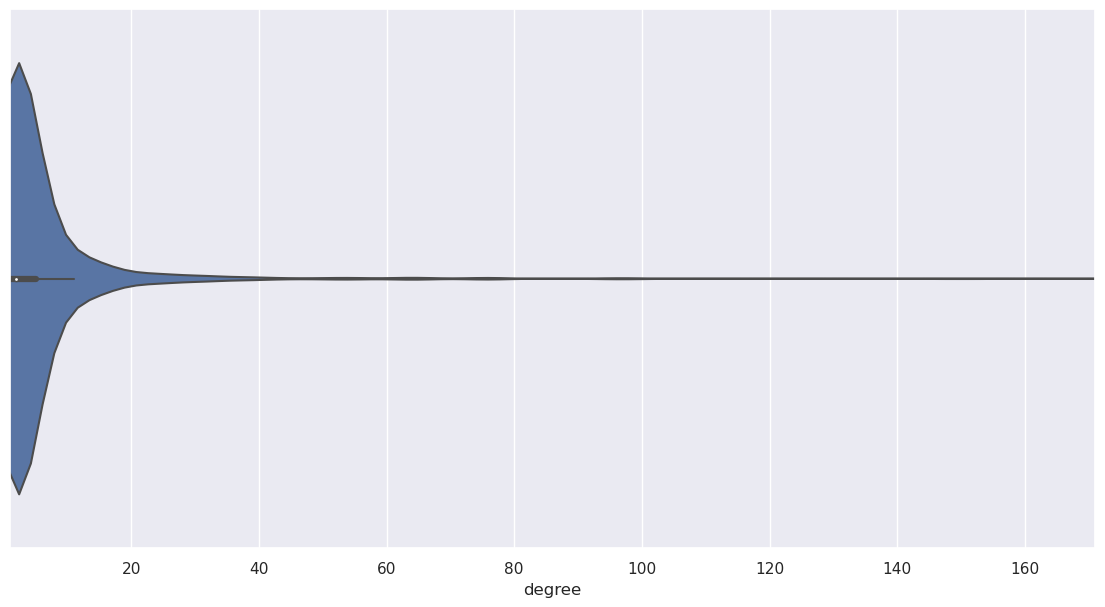

In [196]:
### Violinplot : densité des naissances dans le temps
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

sns.set_theme(style="whitegrid")

sns.set(rc={"figure.figsize":(14, 7)})

a = export['degree'].dropna()
lim_left=min(a)
lim_right=max(a)





ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=lim_left, right=lim_right)


In [197]:
kamo = nx.k_core(amO, k=5)

In [198]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
kamo.is_multigraph(),nx.is_connected(kamo) , kamo.number_of_nodes(), kamo.number_of_edges(), nx.density(kamo)


(False, True, 264, 1827, 0.052627030763912896)

In [199]:
components = nx.connected_components(kamo);
components_l = [len(c) for c in sorted(nx.connected_components(kamo), key=len, reverse=True)]
len(components_l), components_l[:5]

(1, [264])

In [200]:
largest_cc = max(nx.connected_components(kamo), key=len)

In [201]:
S = kamo.subgraph(largest_cc).copy()
type(S)


networkx.classes.graph.Graph

### Représenter le graphe

In [202]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html
u = S
## ,nx.is_connected(G_1971_1975) u.is_directed(),
u.is_multigraph(), nx.is_connected(u), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


(False, True, 264, 1827, 0.052627030763912896)

In [203]:
list(u.nodes.data())[1:3]

[('Goddard_Space_Flight_Center',
  {'degree': 5,
   'closeness': 0.3095707052273225,
   'betweenness': 1.50415069806426e-05}),
 ('Radcliffe_College',
  {'degree': 12,
   'closeness': 0.31061102924872974,
   'betweenness': 0.0037826595668227717})]

In [204]:
labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] > 15:
        labels[i[0]]=i[0] 
list(labels.items())[:3]

[('University_of_Cambridge', 'University_of_Cambridge'),
 ('Johns_Hopkins_University', 'Johns_Hopkins_University'),
 ('Massachusetts_Institute_of_Technology',
  'Massachusetts_Institute_of_Technology')]

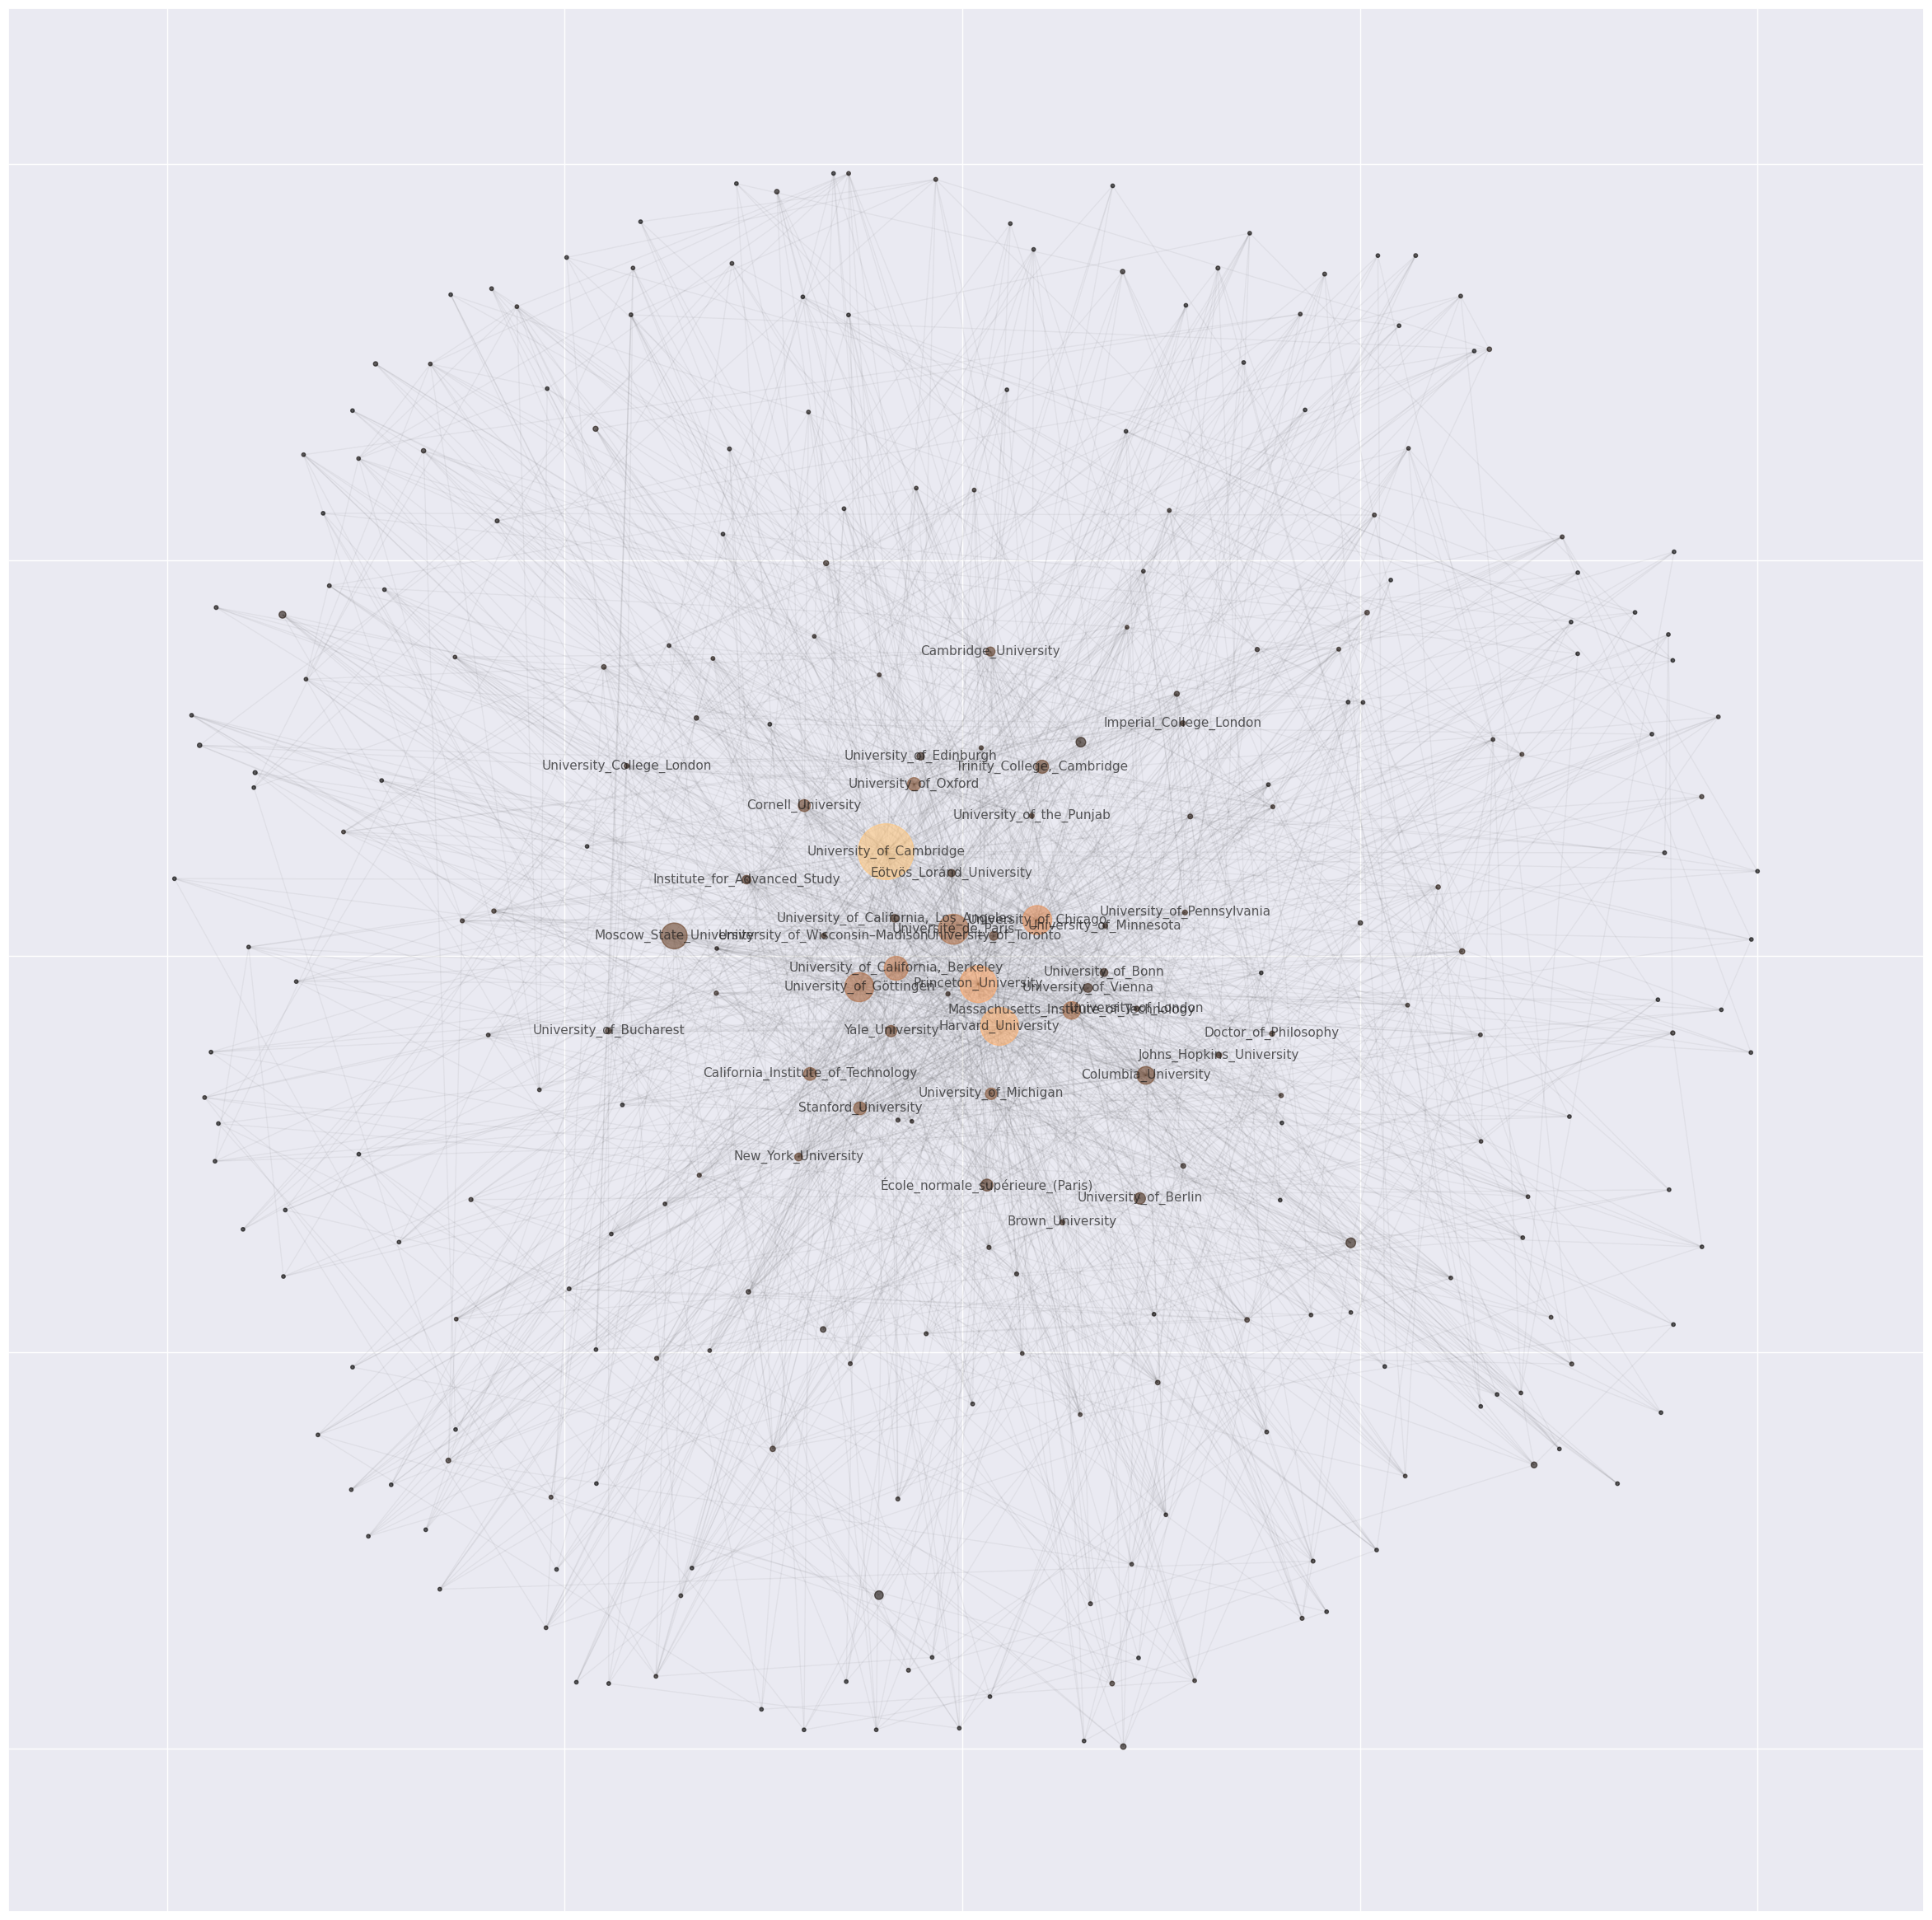

In [205]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(g, k=1)

labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] > 30:
        labels[i[0]]=i[0] 

node_color = [i[1]['degree'] for i in list(u.nodes.data())]

### Adapter la taille des attribut à l'affichage
node_sizes = [i[1]['betweenness']**2 * 100000 + 10 for i in list(u.nodes.data())]


cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_size=node_sizes, node_color=node_color, 
                      cmap='copper', alpha=0.6)
nx.draw_networkx_edges(g, pos, alpha=0.05) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=labels,  alpha=0.7, font_size=11)
#nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)

f = 'pictures/universites.svg'# io.BytesIO()

plt.savefig(f, format="svg")

plt.show()
